In [1]:
#-- Draw anomalies for 1997 and 1998
# idir = "/g/data/p66/ars599/mo_gc3/cq317/apm.pp/netCDF/20*.nc"
%matplotlib inline
import os
import pandas as pd
from netCDF4 import  num2date
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from mpl_toolkits.basemap import Basemap

import os
os.getcwd()

%cd /home/599/ars599/Documents/a10/

import glob
print(glob.glob("/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-1899*mon.nc"))


/home/599/ars599/Documents/a10
['/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189903_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189909_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189906_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189901_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189910_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189907_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189911_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189912_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189908_mon.nc', '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-1899

In [ ]:
import glob
import xarray as xr
from datetime import datetime

# List all matching files
#files = glob.glob('/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-189[01]*mon.nc')


path_of_the_directory = '/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/'
ext = ('mon.nc')
#sst = []
#for files in os.listdir(path_of_the_directory):
#    if files.endswith(ext):
#        file = path_of_the_directory+files
#        print (file)
#        vTmp   = xr.open_dataset(file).fld_s00i024
#        sst    = xr.concat(sst, vTmp, dim=["time"])
#    else:
#        continue

        
        
sst = []
for files in os.listdir(path_of_the_directory):
    if files.endswith(ext):
        file = path_of_the_directory+files
        print (file)
#        ds = xr.open_dataset(file)
#        datasets.append(ds)
        vTmp   = xr.open_dataset(file)['fld_s00i024']
        sst.append(vTmp)


/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-188506_mon.nc
/g/data/p66/ars599/archive/CMIP6/ACCESS-ESM1-5/HI-00/history/atm/netCDF/HI-00.pa-188209_mon.nc


In [ ]:
# batter save the previous variable in to two files (00 and 02)
# to make the workshop easier and can share these two files

[ntim,nlev,nlat,nlon]=np.shape(sst)
combined = xr.concat(sst, dim='time')



In [ ]:
fn = 'sst_HI-00_output.nc'
combined.to_netcdf(fn, "w", format="NETCDF4")

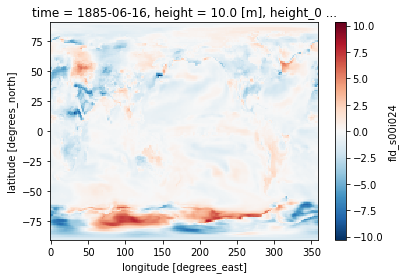

In [34]:
#sst1 = ds1.fld_s00i024
#sst2 = ds2.fld_s00i024
#sst = xr.concat(sst1,sst2,  dim=["time"])
sst = combined
sst_clim = sst.groupby('time.month').mean(dim='time')
sst_anom = sst.groupby('time.month') - sst_clim

%matplotlib inline
sst_anom[0].plot()

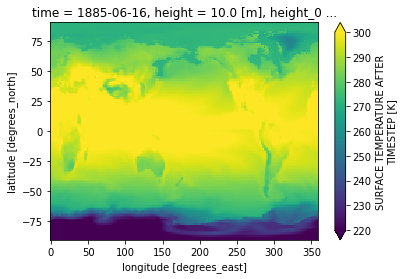

In [40]:
sst.sel(time='1885-06-16').plot(vmin=220, vmax=300)

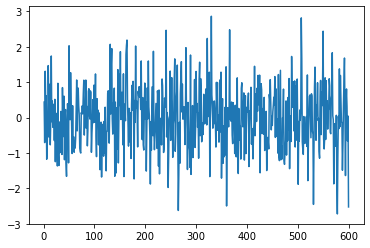

In [57]:
x = list(range(1, 601))
y=sst_anom.time
plt.plot( x,sst_anom.sel(lon=180, lat=0).transpose() )

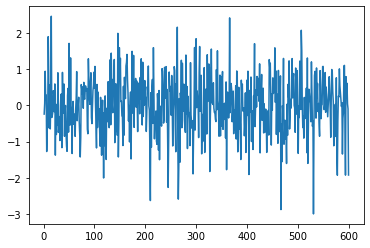

In [60]:
sst_ref = sst_anom.sel(lon=200, lat=0, method='nearest')
plt.plot(x, sst_ref)

In [66]:
# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     lon=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)

# -- correlation and covariance
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

Text(0.5, 1.0, 'Correlation btw. global SST Anomaly and SST Anomaly at one point')

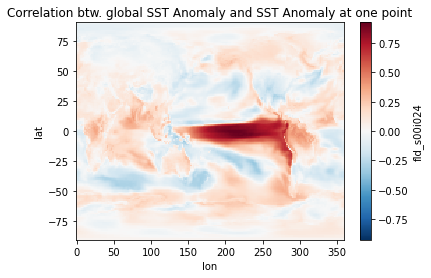

In [71]:
# calculate n34 and correlation plot
n34 = wgt_areaave(sst_anom, -5, 5, 190, 240)
sst_cor = corrrelation(sst_anom, n34, dims='time')
pc = sst_cor.plot()
pc.axes.set_title('Correlation btw. global SST Anomaly and SST Anomaly at one point')

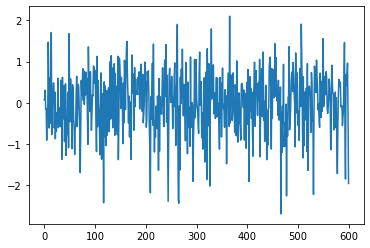

In [72]:
plt.plot(n34)